In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("data/historical_weather.csv")

# parse time as datetime
data["time"] = pd.to_datetime(data["time"])
data.set_index('time', inplace=True)

# rename columns
data.rename(columns={
  "temperature_2m_max (°C)": "max_temp",
  "temperature_2m_min (°C)": "min_temp",
  "temperature_2m_mean (°C)": "mean_temp",
  "precipitation_sum (mm)": "precipitation"
}, inplace=True)

# fix null values
data["precipitation"] = data["precipitation"].replace(np.nan, 0)

# check for null values
# print(data.isnull().sum())

## Temperatura media per ogni anno

Temperatura media per ogni anno, con linea che indica il trend

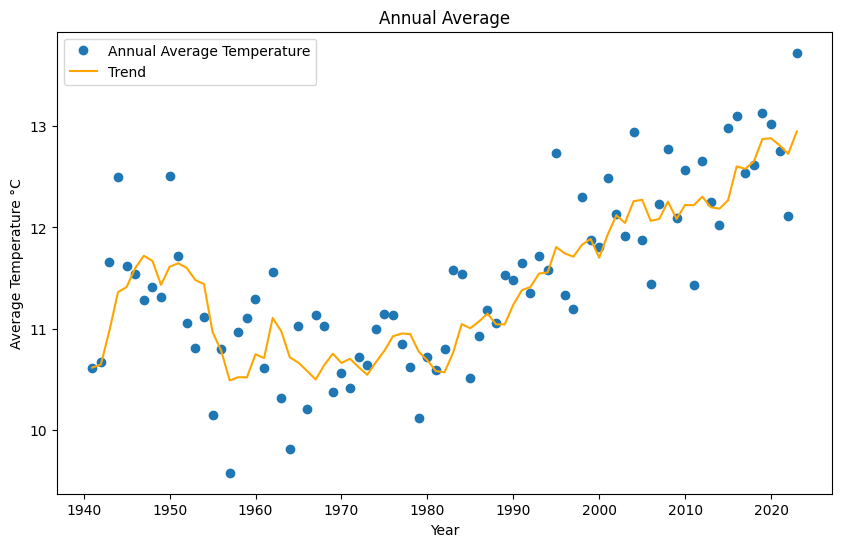

In [49]:
# temperatura media per ogni anno
annual_average = data["mean_temp"].resample('Y').mean()
pd.DataFrame(annual_average)

# trend line
trend_line = annual_average.rolling(window=5, min_periods=1).mean()

# Plot the annual average using dots and the trendline
plt.figure(figsize=(10, 6))
plt.plot(
  annual_average.index,
  annual_average.values,
  marker='o',
  label='Annual Average Temperature',
  linestyle='none'
)
plt.plot(
  trend_line.index,
  trend_line.values,
  color='orange',
  label='Trend'
)
plt.xlabel('Year')
plt.ylabel('Average Temperature °C')
plt.title('Annual Average')
plt.legend()
plt.show()